# ANOVA Testing

Same notebook as 'multiway_anova.ipynb' but only outputting the results deemed to be statistically significant.

## Independant Variables:

- Size of model (tiny or base)
- Use of perspective transformation (prePT or PT)
- Use of HHA encoding
- Use of simulated data

## Dependant Variables (Metrics):

- Specificity
- Sensitivity
- Precision
- Accuracy
- F1-Score
- MCC

Testing with alpha = 0.05

In [1]:
alpha = 0.05

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import itertools
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
from glob import glob
import os

## Data Preparation

In [3]:
files = glob('./*.csv')
print(files)
df = pd.concat([pd.read_csv(fp).assign(Vars=os.path.basename(fp)[:-4]) for fp in files], ignore_index=True)
df.sample(5)

['.\\ViT_Base_HHA.csv', '.\\ViT_Base_HHA_PT.csv', '.\\ViT_Base_prePT.csv', '.\\ViT_Base_PT.csv', '.\\ViT_Base_Sim_HHA.csv', '.\\ViT_Base_Sim_HHA_PT.csv', '.\\ViT_Base_Sim_prePT.csv', '.\\ViT_Base_Sim_PT.csv', '.\\ViT_Tiny_HHA.csv', '.\\ViT_Tiny_HHA_PT.csv', '.\\ViT_Tiny_prePT.csv', '.\\ViT_Tiny_PT.csv', '.\\ViT_Tiny_Sim_HHA.csv', '.\\ViT_Tiny_Sim_HHA_PT.csv', '.\\ViT_Tiny_Sim_prePT.csv', '.\\ViT_Tiny_Sim_PT.csv']


,TP,FP,FN,TN,Specificity,Sensitivity,Precision,Accuracy,F1,MCC,Vars
326,267,44,49,2512,0.982786,0.844937,0.858521,0.967618,0.851675,0.833535,ViT_Tiny_Sim_HHA_PT
219,223,17,21,2831,0.994031,0.913934,0.929167,0.987710,0.921488,0.914858,ViT_Tiny_HHA
164,215,14,29,2834,0.995084,0.881148,0.938865,0.986093,0.909091,0.902102,ViT_Base_Sim_prePT
123,173,31,32,3233,0.990502,0.843902,0.848039,0.981839,0.845966,0.836319,ViT_Base_Sim_HHA
153,142,17,63,3247,0.994792,0.692683,0.893082,0.976939,0.780220,0.775168,ViT_Base_Sim_prePT


In [4]:
df.describe()

,TP,FP,FN,TN,Specificity,Sensitivity,Precision,Accuracy,F1,MCC
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,206.480000,42.215000,45.270000,2753.402500,0.984150,0.819516,0.854490,0.970581,0.829584,0.817741
std,49.073007,51.627777,26.963302,1518.248402,0.019744,0.101534,0.102361,0.020183,0.088897,0.088936
min,31.000000,0.000000,5.000000,944.000000,0.841158,0.098101,0.361552,0.840181,0.178161,0.291292
25%,168.000000,17.000000,28.000000,2435.750000,0.982315,0.771325,0.835424,0.966723,0.794814,0.777987
50%,204.000000,27.000000,41.000000,2504.000000,0.990169,0.844082,0.883444,0.975209,0.851907,0.836716
75%,252.000000,45.000000,56.000000,2833.250000,0.994031,0.885246,0.916065,0.982516,0.885285,0.875028
max,300.000000,406.000000,285.000000,32350.000000,1.000000,0.974093,1.000000,0.997974,0.939086,0.934594


In [5]:
df.loc[df['Vars'].str.contains('Base'), 'model_size'] = 'Base'
df.loc[df['Vars'].str.contains('Tiny'), 'model_size'] = 'Tiny'
df.loc[df['Vars'].str.contains('HHA'), 'Encoding'] = 'HHA'
df.loc[df['Vars'].str.contains('HHA') == False, 'Encoding'] = 'Depth'
df.loc[df['Vars'].str.contains('prePT') | (df['Vars'].str.contains('PT') == False), 'Transformation'] = 'None'
df.loc[(df['Vars'].str.contains('prePT') == False) & df['Vars'].str.contains('PT'), 'Transformation'] = 'PT'
df.loc[df['Vars'].str.contains('Sim'), 'Simulated_Data'] = 'Sim'
df.loc[df['Vars'].str.contains('Sim') == False, 'Simulated_Data'] = 'None'

del df['Vars']

In [6]:
df.sample(5)

,TP,FP,FN,TN,Specificity,Sensitivity,Precision,Accuracy,F1,MCC,model_size,Encoding,Transformation,Simulated_Data
153,142,17,63,3247,0.994792,0.692683,0.893082,0.976939,0.780220,0.775168,Base,Depth,None,Sim
399,205,362,39,2486,0.872893,0.840164,0.361552,0.870310,0.505549,0.496783,Tiny,Depth,PT,Sim
13,172,24,33,3240,0.992647,0.839024,0.877551,0.983569,0.857855,0.849381,Base,HHA,None,None
186,273,36,43,2520,0.985915,0.863924,0.883495,0.972493,0.873600,0.858237,Base,Depth,PT,Sim
367,232,45,70,2482,0.982192,0.768212,0.837545,0.959350,0.801382,0.779689,Tiny,Depth,None,Sim


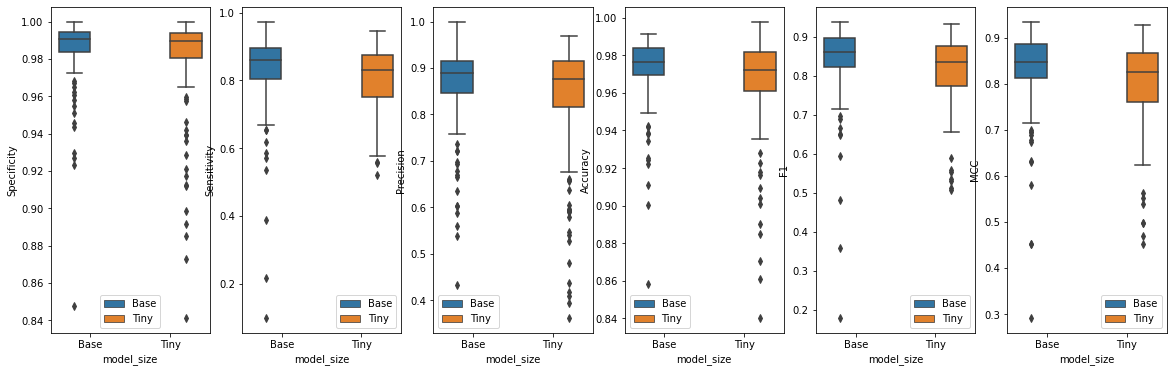

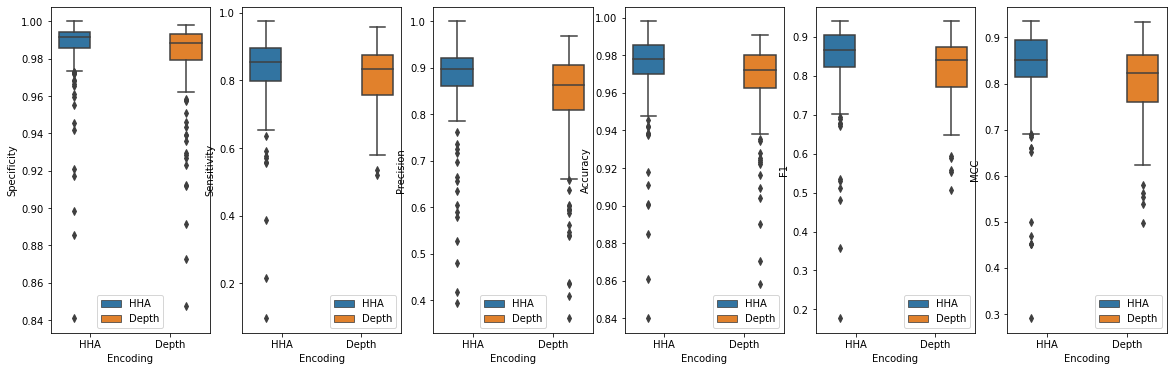

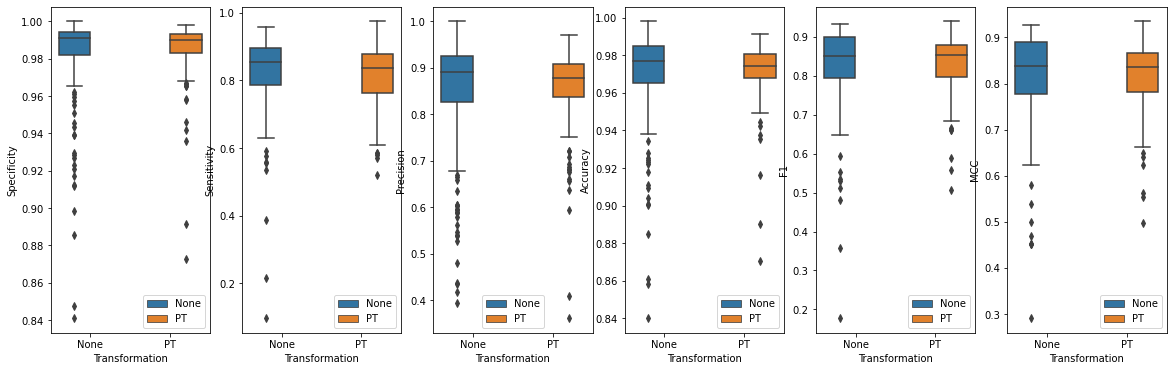

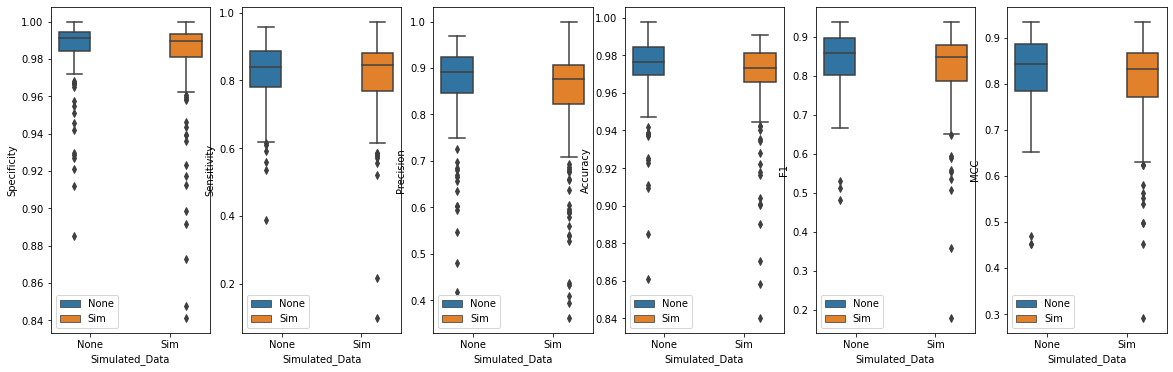

In [14]:
metrics = ['Specificity', 'Sensitivity', 'Precision', 'Accuracy', 'F1', 'MCC']
vars = ['model_size', 'Encoding', 'Transformation', 'Simulated_Data']

for var in vars:
    fig, axs = plt.subplots(ncols=len(metrics))
    plt.setp(fig, size_inches=(20, 6))
    for idx, metric in enumerate(metrics):
        sns.boxplot(data=df, x=var, y=metric, hue=df[var].tolist(), ax=axs[idx])
    plt.show()

## N-Way ANOVA

Where N is the number of independent variables.

We test each combination of the 4 independent variables on each of the 6 dependant variables separately

In [7]:
metrics = ['Specificity', 'Sensitivity', 'Precision', 'Accuracy', 'F1', 'MCC']
vars = ['model_size', 'Encoding', 'Transformation', 'Simulated_Data']

# Build right half of formula
independantString = ''
for i in range(1, len(vars) + 1):
    combs = list(itertools.combinations(vars, i))
    for comb in combs:
        if independantString != '':
            independantString += ' + '
        independantString_sub = ''
        for var in comb:
            if independantString_sub == '':
                independantString_sub = f'C({var})'
            else:
                independantString_sub += f':C({var})'
        independantString += independantString_sub

for metric in metrics:
    model = ols(f'{metric} ~ {independantString}', data=df).fit()

    result = sm.stats.anova_lm(model, type=2)
    result = result.loc[(result['PR(>F)'] <= alpha) & (result['PR(>F)'] != 0)]
    if result.shape[0] > 0:
        print(f'Variables that have a statistically significant effect on {metric}:')
        for variable in result.index.values:
            if variable != 'Intercept':
                print(variable)
        print('\n')

Variables that have a statistically significant effect on Specificity:
C(model_size)
C(Encoding)
C(Transformation)
C(Simulated_Data)
C(model_size):C(Encoding):C(Transformation):C(Simulated_Data)


Variables that have a statistically significant effect on Sensitivity:
C(model_size)
C(Encoding)
C(Encoding):C(Transformation)


Variables that have a statistically significant effect on Precision:
C(model_size)
C(Encoding)
C(Simulated_Data)
C(Encoding):C(Simulated_Data)
C(model_size):C(Encoding):C(Transformation):C(Simulated_Data)


Variables that have a statistically significant effect on Accuracy:
C(model_size)
C(Encoding)
C(Simulated_Data)
C(Encoding):C(Transformation)


Variables that have a statistically significant effect on F1:
C(model_size)
C(Encoding)
C(Simulated_Data)
C(Encoding):C(Transformation)


Variables that have a statistically significant effect on MCC:
C(model_size)
C(Encoding)
C(Simulated_Data)
C(Encoding):C(Transformation)




## Multivariate ANOVA (MANOVA)

We test each of the 4 independent variables separately on each combination of the 6 dependant variables (MANOVA)

In [8]:
metrics = ['Specificity', 'Sensitivity', 'Precision', 'Accuracy', 'F1', 'MCC']
vars = ['model_size', 'Encoding', 'Transformation', 'Simulated_Data']

for i in range(2, len(metrics) + 1):
    metric_combs = list(itertools.combinations(metrics, i))
    for comb in metric_combs:
        dependantString = ''
        for metric in comb:
            if dependantString != '':
                dependantString += ' + '
            dependantString += metric
        
        for var in vars:
            independantString = f'C({var})'
            maov = MANOVA.from_formula(f'{dependantString} ~ {independantString}', data=df)
            result = maov.mv_test().summary_frame
            result.drop('Pillai\'s trace', level=1, axis=0, inplace=True)
            result.drop('Hotelling-Lawley trace', level=1, axis=0, inplace=True)
            result.drop('Roy\'s greatest root', level=1, axis=0, inplace=True)
            result = result.reset_index(level=[1])
            del result['Statistic']

            result = result.loc[(result['Pr > F'] <= alpha) & (result['Pr > F'] != 0)]

            # result = result.iloc[:,0]
            # print(result)
            if result.shape[0] > 0:
                print(f'Variables that have a statistically significant effect on {dependantString}:')
                for variable in result.index.values:
                    if variable != 'Intercept':
                        print(variable)
                print('\n')
            # print(maov.mv_test(), '\n')


Variables that have a statistically significant effect on Specificity + Sensitivity:
C(model_size)


Variables that have a statistically significant effect on Specificity + Sensitivity:
C(Encoding)


Variables that have a statistically significant effect on Specificity + Precision:
C(model_size)


Variables that have a statistically significant effect on Specificity + Precision:
C(Encoding)


Variables that have a statistically significant effect on Specificity + Precision:
C(Simulated_Data)


Variables that have a statistically significant effect on Specificity + Accuracy:
C(model_size)


Variables that have a statistically significant effect on Specificity + Accuracy:
C(Encoding)


Variables that have a statistically significant effect on Specificity + F1:
C(model_size)


Variables that have a statistically significant effect on Specificity + F1:
C(Encoding)


Variables that have a statistically significant effect on Specificity + F1:
C(Simulated_Data)


Variables that have a statist

## N-Way Multivariate ANOVA (N-Way MANOVA)

Where N is the number of independent variables.

We test each combination of the 4 independent variables on each combination of the 6 dependant variables (MANOVA)

In [18]:
metrics = ['Specificity', 'Sensitivity', 'Precision', 'Accuracy', 'F1', 'MCC']
vars = ['model_size', 'Encoding', 'Transformation', 'Simulated_Data']

# Build right half of formula
independantString = ''
for i in range(1, len(vars) + 1):
    var_combs = list(itertools.combinations(vars, i))
    for comb in var_combs:
        if independantString != '':
            independantString += ' + '
        independantString_sub = ''
        for var in comb:
            if independantString_sub == '':
                independantString_sub = f'C({var})'
            else:
                independantString_sub += f':C({var})'
        independantString += independantString_sub

for i in range(2, len(metrics) + 1):
    metric_combs = list(itertools.combinations(metrics, i))
    for comb in metric_combs:
        dependantString = ''
        for metric in comb:
            if dependantString != '':
                dependantString += ' + '
            dependantString += metric
        maov = MANOVA.from_formula(f'{dependantString} ~ {independantString}', data=df)
        result = maov.mv_test()
        df_result = result.summary_frame
        df_result.drop('Pillai\'s trace', level=1, axis=0, inplace=True)
        df_result.drop('Hotelling-Lawley trace', level=1, axis=0, inplace=True)
        df_result.drop('Roy\'s greatest root', level=1, axis=0, inplace=True)
        df_result = df_result.reset_index(level=[1])
        del df_result['Statistic']

        # result = result.loc[(result['Pr > F'] <= alpha) & (result['Pr > F'] != 0)]
        # result = result.iloc[:,0]
        # print(result)
        # if df_result.shape[0] > 0:
        #     print(f'Variables that have a statistically significant effect on {dependantString}:')
            # for variable in result.index.values:
            #     if variable != 'Intercept':
            #         print(variable)
            # print('\n')
        # print(maov.mv_test(), '\n')
        print(f'MANOVAs for {dependantString}:')
        print(df_result)
        # print(tabulate(df_result, headers='keys', tablefmt='rst'), '\n')


MANOVAs for Specificity + Sensitivity:
                                                       Value Num DF Den DF  \
Effect                                                                       
Intercept                                           0.005359      2  383.0   
C(model_size)                                       0.994931      2  383.0   
C(Encoding)                                         0.999747      2  383.0   
C(Transformation)                                   0.996837      2  383.0   
C(Simulated_Data)                                   0.994282      2  383.0   
C(model_size):C(Encoding)                           0.999783      2  383.0   
C(model_size):C(Transformation)                     0.998975      2  383.0   
C(model_size):C(Simulated_Data)                      0.99832      2  383.0   
C(Encoding):C(Transformation)                       0.996418      2  383.0   
C(Encoding):C(Simulated_Data)                       0.988349      2  383.0   
C(Transformation):C(Simul